# Googleによる量子超越実験の（小規模）シミュレーション

日本物理学会誌○○月号、「最近のトピック」に掲載予定の付録として、Googleの論文で実行されたlinear cross entropy benchmark で行われているタスクを量子コンピュータのシミュレーターを用いて解説します。シミュレータとしては、qulacs を用いました。qulacsのインストールについては、[ここ](https://github.com/qulacs/qulacs/blob/master/doc/1_HowToInstall.md)を参考にしてください。 qulacsについては、 [github](http://qulacs.org)、もしくは[これ](/Qulacs_introduction.ipynb)を参考にしてください。量子計算の基礎や高度なqulacsの使い方については、[Quantum Native Dojo](https://dojo.qulacs.org)をご参照ください。

まず、以下で必要なモジュールを読み込みます。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time 
import random
from qulacs import QuantumState
#GPU版をインストールしている場合のみ
#from qulacs import QuantumStateGpu
from qulacs import QuantumCircuit
from qulacs.gate import DenseMatrix
from qulacs.circuit import QuantumCircuitOptimizer
from qulacs.state import inner_product
from qulacs.gate import Identity, X,Y,Z #パウリ演算子
from qulacs.gate import H,S,Sdag, sqrtX,sqrtXdag,sqrtY,sqrtYdag #1量子ビット Clifford演算
from qulacs.gate import T,Tdag #1量子ビット 非Clifford演算
from qulacs.gate import RX,RY,RZ #パウリ演算子についての回転演算
from qulacs.gate import CNOT, CZ, SWAP #2量子ビット演算
from qulacs.gate import DephasingNoise,DepolarizingNoise,TwoQubitDepolarizingNoise

正方格子上に配置された量子ビットの番号を簡単に指定するための関数を用意しておく。

In [2]:
#xy座標から通し番号を出力
def GridtoId(x,y,length):
    return x+length*y

#通し番号からxy座標を出力
def IdtoGrid(id,length):
    return np.array([id%length,(id-id%length)/length],dtype = int)

#グリッド内にいるかどうか判定
def InGrid(x,y,length):
    if x<length and y<length and x>=0 and y>=0:
        return 0
    else:
        return 1

グリッド上で作用する演算をいくつか定義しておく。

In [3]:
#グリッド上でCZ gateを作用
def grid_CZ_gate(qubit1,qubit2,length):
    if InGrid(qubit1[0],qubit1[1],length)==0 and InGrid(qubit2[0],qubit2[1],length)==0:
        circuit.add_gate(CZ(GridtoId(qubit1[0],qubit1[1],length),GridtoId(qubit2[0],qubit2[1],length)))

#グリッド上で2qubit gateを作用
def grid_2Q_gate(qubit1,qubit2,length,gate_array,circuit):
    if InGrid(qubit1[0],qubit1[1],length)==0 and InGrid(qubit2[0],qubit2[1],length)==0:
        circuit.add_gate(DenseMatrix([GridtoId(qubit1[0],qubit1[1],length),GridtoId(qubit2[0],qubit2[1],length)],gate_array))  

#グリッド上で1qubit gateを作用
def grid_1Q_gate(qubitId,circuit,gate_type):
    if gate_type == 0:
        circuit.add_gate(sqrtX(qubitId))
    elif gate_type == 1:
        circuit.add_gate(sqrtY(qubitId))
    elif gate_type == 2:
        circuit.add_gate(DenseMatrix(qubitId,[[1/np.sqrt(2.0),- np.sqrt(1.0j/2.0)],[np.sqrt(-1.0j/2.0),1/np.sqrt(2.0)]]))


#グリッド上でrandom 1Q gateを作用        
def random_1Q_gate(qubitId,circuit):
    hoge =1
    prob = random.random()
    if prob < 1.0/3.0:
        circuit.add_gate(sqrtX(qubitId))
    elif prob < 2.0/3.0:
        circuit.add_gate(sqrtY(qubitId))
    else:
        circuit.add_gate(DenseMatrix(qubitId,[[1/np.sqrt(2.0),- np.sqrt(1.0j/2.0)],[np.sqrt(-1.0j/2.0),1/np.sqrt(2.0)]]))
        #circuit.add_gate(T(qubitId))

Googleが使っている２量子ビット演算（iSwapLikeGate）を指定するための配列を定義しておきます。

In [21]:
theta = np.pi/2.0
iSwapLikeGate = [[1,0,0,0],
                [0,np.cos(theta),-1.0j*np.sin(theta),0],
                [0,-1.0j*np.sin(theta),np.cos(theta),0],
                [0,0,0,1]]
print(np.array(iSwapLikeGate))

[[1.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 6.123234e-17+0.j 0.000000e+00-1.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00-1.j 6.123234e-17+0.j 0.000000e+00+0.j]
 [0.000000e+00+0.j 0.000000e+00+0.j 0.000000e+00+0.j 1.000000e+00+0.j]]


とりあえず、きちんと動くかテストしてみる。

In [5]:
#正方格子のサイズ
length = 2
#量子ビットの数
nqubits = length**2

state = QuantumState(nqubits)
state.set_zero_state()
circuit = QuantumCircuit(nqubits)

for i in range(nqubits):
    H(i).update_quantum_state(state)
print(state)

grid_2Q_gate([0,0],[1,0],length,iSwapLikeGate,circuit)

circuit.update_quantum_state(state)
print(state)

 *** Quantum State ***
 * Qubit Count : 4
 * Dimension   : 16
 * State vector : 
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)
(0.25,0)

 *** Quantum State ***
 * Qubit Count : 4
 * Dimension   : 16
 * State vector : 
           (0.25,0)
(1.53081e-17,-0.25)
(1.53081e-17,-0.25)
           (0.25,0)
           (0.25,0)
(1.53081e-17,-0.25)
(1.53081e-17,-0.25)
           (0.25,0)
           (0.25,0)
(1.53081e-17,-0.25)
(1.53081e-17,-0.25)
           (0.25,0)
           (0.25,0)
(1.53081e-17,-0.25)
(1.53081e-17,-0.25)
           (0.25,0)



ランダム量子回路を生成する関数を作る。depthが論文でのcycleに対応します。論文では、A-type、B-type、C-type、D-typeの４通りの隣接する量子ビット間に作用する２量子ビット演算が定義されている。ここでは、簡単のため、A,B,C,Dの順に作用させて行くことにします。

In [6]:
#テスト用回路：アダマール演算を用いて全てのビット列の重ね合わせ状態を生成
def test_circuit(length,circuit):
    num_qubits = length**2
    for i in range(num_qubits):
        circuit.add_gate(H(i))

def Google_random_circuit(length,depth,circuit):
    num_qubits = length**2

    for k in range(depth):
        if k%4 == 0:
            #cycle A
            #ランダムに1量子ビット演算を追加
            for i in range(num_qubits):
                random_1Q_gate(i,circuit)

            #２量子ビットを追加
            for i in range(length):
                for j in range(length):
                    if (i+j)%2 == 0:
                        grid_2Q_gate([i,j],[i+1,j],length,iSwapLikeGate,circuit)
                        

        if k%4 == 1:
            #cycle B
            #ランダムに1量子ビット演算を追加
            for i in range(num_qubits):
                random_1Q_gate(i,circuit)

            #２量子ビットを追加
            for i in range(length):
                for j in range(length):
                    if (i+j)%2 == 0:
                        grid_2Q_gate([i,j],[i-1,j],length,iSwapLikeGate,circuit)

        if k%4 == 2:
            #cycle C
            #ランダムに1量子ビット演算を追加
            for i in range(num_qubits):
                random_1Q_gate(i,circuit)

            #２量子ビットを追加
            for i in range(length):
                for j in range(length):
                    if (i+j)%2 == 0:
                        grid_2Q_gate([i,j],[i,j+1],length,iSwapLikeGate,circuit)

        if k%4 == 3:
            #cycle D
            #ランダムに1量子ビット演算を追加
            for i in range(num_qubits):
                random_1Q_gate(i,circuit)

            #２量子ビットを追加
            for i in range(length):
                for j in range(length):
                    if (i+j)%2 == 0:
                        grid_2Q_gate([i,j],[i,j-1],length,iSwapLikeGate,circuit)



回路要素がきちんと構成されているか確認しておきます。

In [7]:
#格子の横の長さ
length = 4
#量子ビット数
nqubits = length**2
#計算の深さ、cycleに相当
depth = 1

#量子回路を確保
circuit =QuantumCircuit(nqubits)
#googleのランダム量子回路を構成
Google_random_circuit(length,depth,circuit)
print(circuit)

*** Quantum Circuit Info ***
# of qubit: 16
# of step : 2
# of gate : 22
# of 1 qubit gate: 16
# of 2 qubit gate: 6
Clifford  : no
Gaussian  : no




テスト回路でサンプリングを実行。

In [8]:
num_samp = 100
length = 2
nqubits = length**2
depth = 10

state =QuantumState(nqubits)
circuit =QuantumCircuit(nqubits)

test_circuit(length,circuit)
circuit.update_quantum_state(state)
result = state.sampling(num_samp)
print(result)

[15, 9, 1, 9, 10, 4, 11, 6, 2, 12, 14, 2, 0, 4, 8, 9, 2, 9, 14, 14, 5, 7, 0, 5, 10, 5, 12, 7, 3, 13, 13, 7, 3, 10, 0, 14, 9, 2, 6, 14, 1, 15, 4, 0, 6, 9, 5, 6, 13, 9, 3, 9, 8, 13, 6, 14, 12, 15, 5, 9, 14, 4, 11, 5, 5, 4, 10, 10, 6, 6, 1, 7, 6, 11, 1, 10, 0, 15, 0, 3, 12, 8, 11, 13, 15, 12, 4, 11, 5, 6, 0, 11, 7, 14, 14, 14, 6, 14, 8, 15]


ビット列の10進数表示が得られています。25量子ビットのランダム量子回路で10サンプリングするのにノートPC（MacBook Pro 3.5 GHz Intel Core i7）でどれくらいの時間がかかるか計測してみましょう。

In [40]:
num_samp = 10

length = 5
nqubits = length**2
depth = 10


st = time.time()
state =QuantumState(nqubits)
circuit =QuantumCircuit(nqubits)

Google_random_circuit(length,depth,circuit)
circuit.update_quantum_state(state)
result = state.sampling(num_samp)
els = time.time()-st
print(els)

26.96825075149536


約２５秒かかりました。少々横暴な見積もりですが、1つ量子ビットが増えるごとに複素数の次元は２倍になり、計算時間も２倍になるとして50量子ビットの場合は、
$$
27 \times 2^{25} 
$$
また、1000回サンプリング（忠実度0.001で$10^6$回サンプルするためにはこれくらい必要）するとし、さらに、$10^6$コアの並列計算機で並列化し、メモリアクセスのボトルネックやノード間並列に要するコストを完全に無視して$10^6$倍高速化できたとし、秒から日に換算すると、
$$
27 \times 2^{25} \times 10^3 / 10^6 / 86400 \sim 10
$$
約10日かかることになります。GPUなど並列性の高いマシンを用いればさらに高速化されるでしょう（IBMの見積もりでは、スーパーコンピュータサミットを用いて、53量子ビット、20cycleのシミュレーションが2.5日ということでした）。50量子ビットで、倍精度では16Pbyteのデータを確保する必要があります。この見積もりは、波動関数の情報を全て確保した場合ですが、データを全て確保できない場合は、経路積分法のように量子計算を特定のパスに分割し足し合わせるという方法をとる必要があり、さらに計算時間がかかることになります。

さて、サンプリングした結果の処理に入ります。整理してヒストグラムをプロットする関数を定義しておきます。

In [9]:
def plot_histgram(nqubits,result,num_samp):
    dim = 2**nqubits

    counts = [0 for i in range(dim)]
    for i in range(num_samp):
        counts[result[i]] += 1
    counts.sort()
#    plt.yscale("log")
    plt.plot(counts)
    
def plot_histgram_multi(nqubits,depth_result,num_multi,num_samp):
    dim = 2**nqubits
    for k in range(num_multi):
        counts = [0 for i in range(dim)]
        for i in range(num_samp):
            counts[depth_result[k][i]] += 1
        counts.sort()

        plt.plot(counts)
    plt.show()

さて、実際にランダム量子回路を実行しヒストグラムをプロットしてみましょう。

*** Quantum Circuit Info ***
# of qubit: 16
# of step : 40
# of gate : 440
# of 1 qubit gate: 320
# of 2 qubit gate: 120
Clifford  : no
Gaussian  : no




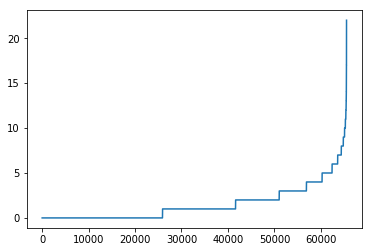

In [11]:
num_samp = 100000
length = 4
nqubits = length**2
depth = 20

state =QuantumState(nqubits)
circuit =QuantumCircuit(nqubits)
#state.set_Haar_random_state()

Google_random_circuit(length,depth,circuit)
print(circuit)
circuit.update_quantum_state(state)

result = state.sampling(num_samp)
plot_histgram(nqubits,result,num_samp)

qulacsには完全にランダムな状態（Haar random状態）を生成する機能があるので、それに対してサンプリングした場合と比較してみましょう。

10.668841944186056 10.667354888959125


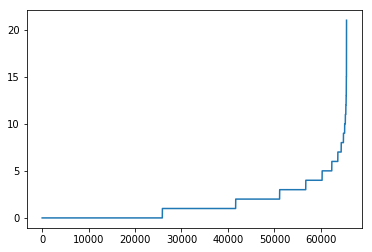

In [12]:
num_samp = 100000
length = 4
nqubits = length**2
depth = 5

state =QuantumState(nqubits)
circuit =QuantumCircuit(nqubits)
state.set_Haar_random_state()
print(state.get_entropy(),np.log(2.0**nqubits)-1+0.577)

Haar_result = state.sampling(num_samp)
plot_histgram(nqubits,Haar_result,num_samp)

同じようなヒストグラムが得られます。この分布は、Porter-Thomas分布とよばれています。次にエントロピーを計算してみましょう。

In [84]:
num_samp = 1000000
length = 4
nqubits = length**2
max_depth = 20

depth_result = []
entropy_res = []
st = time.time()
state =QuantumState(nqubits)

for k in range(max_depth):
    depth=k
    state.set_zero_state()
    circuit =QuantumCircuit(nqubits)
    #state.set_Haar_random_state()

    Google_random_circuit(length,depth,circuit)
#    print(circuit)
    circuit.update_quantum_state(state)
    entropy_res.append(state.get_entropy())
    result = state.sampling(num_samp)
    depth_result.append(result)
#    plot_histgram(nqubits,result,num_samp)
elp = time.time()-st
print(elp)

4.334930896759033


計算の深さに対して、エントロピーをプロットすると、PT分布のエントロピーにdepth=5くらいで到達することがわかります。

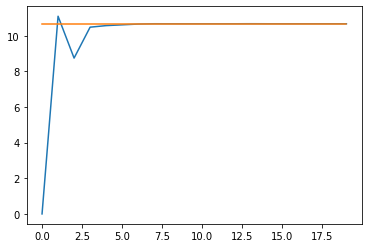

In [85]:
plt.plot(entropy_res)
plt.plot([np.log(2.0**nqubits)-1+0.577 for i in range(20)])
plt.show()

実際の実験ではノイズが入ります。qulacsにはノイズをシミュレーションする機能もあるので、ノイズが入ることによって、得られる分布がどのようになるのか確認してみましょう。まずはノイズのある演算およびノイズのあるランダム量子回路を定義します。ノイズとしては、簡単のために以下のような1量子ビットのdepolarizing noiseと2量子ビットのdepolarizing noiseを採用しました。

$$
\mathcal{E}(\rho) = (1-p)\rho + \frac{p}{3}\sum _{A=X,Y,Z} A \rho A
$$
$$
\mathcal{E}(\rho) = (1-p)\rho + \frac{p}{15}\sum _{A\otimes B \in \{ I,X,Y,Z\}^{\otimes 2} \backslash  I\otimes I} A\otimes B \rho A \otimes B
$$

In [15]:
def noisy_random_1Q_gate(noise_rate,qubitId,circuit):
    prob = random.random()

    if prob < 1.0/3.0:
        circuit.add_gate(sqrtX(qubitId))
    
    elif prob < 2.0/3.0:
        circuit.add_gate(sqrtY(qubitId))
    
    else:
        circuit.add_gate(DenseMatrix(qubitId,[[1/np.sqrt(2.0),- np.sqrt(1.0j/2.0)],[np.sqrt(-1.0j/2.0),1/np.sqrt(2.0)]]))
    
    circuit.add_gate(DepolarizingNoise(qubitId,noise_rate))
        
def noisy_grid_2Q_gate(noise_rate,qubit1,qubit2,length,gate_array,circuit):
    if InGrid(qubit1[0],qubit1[1],length)==0 and InGrid(qubit2[0],qubit2[1],length)==0:
        circuit.add_gate(DenseMatrix([GridtoId(qubit1[0],qubit1[1],length),GridtoId(qubit2[0],qubit2[1],length)],gate_array))  
        circuit.add_gate(TwoQubitDepolarizingNoise(GridtoId(qubit1[0],qubit1[1],length),GridtoId(qubit2[0],qubit2[1],length),noise_rate))

def noisy_Google_random_circuit(noise_rate,length,depth,circuit):
    num_qubits = length**2

    for k in range(depth):
        #cycle A
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            noisy_random_1Q_gate(noise_rate,i,circuit)

        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    noisy_grid_2Q_gate(noise_rate,[i,j],[i+1,j],length,iSwapLikeGate,circuit)
                  


        #cycle B
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            noisy_random_1Q_gate(noise_rate,i,circuit)
            

        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    noisy_grid_2Q_gate(noise_rate,[i,j],[i-1,j],length,iSwapLikeGate,circuit)



        #cycle C
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            noisy_random_1Q_gate(noise_rate,i,circuit)
            

            
        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    noisy_grid_2Q_gate(noise_rate,[i,j],[i,j+1],length,iSwapLikeGate,circuit)


        #cycle D
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            noisy_random_1Q_gate(noise_rate,i,circuit)
           

        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    noisy_grid_2Q_gate(noise_rate,[i,j],[i,j-1],length,iSwapLikeGate,circuit)
                    
    #測定ノイズ            
    for i in range(num_qubits):
        circuit.add_gate(DepolarizingNoise(i,noise_rate))

ノイズ（depolarizing noise）のシミュレーションでは、updateごとにノイズの入る場所が変わる（でなければノイズではない）のでサンプリングごとに状態をupdateする必要があるので、シミュレーションにかなり時間がかかります。

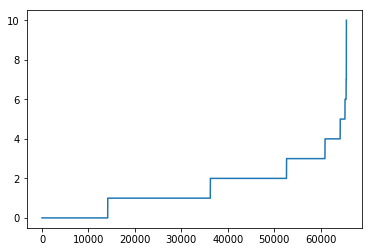

In [18]:
num_samp = 100000
length = 4
nqubits = length**2
depth = 10
noise_rate=0.01

state =QuantumState(nqubits)
circuit =QuantumCircuit(nqubits)
noisy_Google_random_circuit(noise_rate,length,depth,circuit)

result = []
for i in range(num_samp):
    state.set_zero_state()
    circuit.update_quantum_state(state)
    result.append(state.sampling(1)[0])
    
plot_histgram(nqubits,result,num_samp)
#plot_histgram(nqubits,Haar_random,num_samp)
plt.show()

先ほどの分布に比べて、ヒストグラムの裾野が広がっていることがわかります。ノイズによって本来出るはずのないビット列がサンプリングされていることがわかります。実際にはどれくらいの忠実度がでているでしょうか？量子状態を測定によって完全に特定し、式として記述できれば理想的な状態とのオーバーラップを計算すれば忠実度
$$
F = \langle \psi _{\rm ideal} | \rho _{\rm noisy} | \psi _{\rm ideal} \rangle
$$
を計算することもできますが、量子ビット数が増えるとこのようなことは到底できません。

以下では、linear cross-entropy benchamrkを用いて実際の量子回路の全体のフィデリティがどれくらいあるかを、サンプリングしたビット列から計算する方法を説明します。

このときサンリングによって得られた$M$個のビット列$x_i$に対して、
$$
F_{\rm XEB} = 2^n \frac{1}{M} \sum_i P(x_i) 
$$
を計算してみましょう。（実際にはランダムな量子回路のインスタンスに対しても平均を取る必要があります）

1量子ビット演算はランダムに選ばれるのでインスタンスごとに違うものになってしまう仕様でした。理想的な回路とノイズの入った回路において比較するために、１量子ビット演算のインスタンスを指定できるように演算、回路を改造します（以下では1depth毎に4つの1量子ビット演算と A,B,C,D それぞれのタイプの2量子ビット演算を作用させます。depth×8の計算スッテプが含まれます）。

In [8]:
def noisy_grid_1Q_gate(noise_rate,qubitId,circuit,gate_type):

    if gate_type == 0:
        circuit.add_gate(sqrtX(qubitId))
    elif gate_type == 1:
        circuit.add_gate(sqrtY(qubitId))
    elif gate_type == 2:
        circuit.add_gate(DenseMatrix(qubitId,[[1/np.sqrt(2.0),- np.sqrt(1.0j/2.0)],[np.sqrt(-1.0j/2.0),1/np.sqrt(2.0)]]))

    circuit.add_gate(DepolarizingNoise(qubitId,noise_rate))

def fixed_Google_random_circuit(length,depth,circuit,gate_set):
    num_qubits = length**2
    step = 0

    for k in range(depth):
        #cycle A
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            grid_1Q_gate(i,circuit,gate_set[step])
            step += 1

        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    grid_2Q_gate([i,j],[i+1,j],length,iSwapLikeGate,circuit)


        #cycle B
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            grid_1Q_gate(i,circuit,gate_set[step])
            step += 1

        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    grid_2Q_gate([i,j],[i-1,j],length,iSwapLikeGate,circuit)


        #cycle C
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            grid_1Q_gate(i,circuit,gate_set[step])
            step += 1



        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    grid_2Q_gate([i,j],[i,j+1],length,iSwapLikeGate,circuit)


        #cycle D
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            grid_1Q_gate(i,circuit,gate_set[step])
            step += 1


        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    grid_2Q_gate([i,j],[i,j-1],length,iSwapLikeGate,circuit)




def fixed_noisy_Google_random_circuit(noise_rate,length,depth,circuit,gate_set):
    num_qubits = length**2
    step =0 
    for k in range(depth):
        #cycle A
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            noisy_grid_1Q_gate(noise_rate,i,circuit,gate_set[step])
            step += 1



        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    noisy_grid_2Q_gate(noise_rate,[i,j],[i+1,j],length,iSwapLikeGate,circuit)
                  


        #cycle B
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            noisy_grid_1Q_gate(noise_rate,i,circuit,gate_set[step])
            step += 1


            

        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    noisy_grid_2Q_gate(noise_rate,[i,j],[i-1,j],length,iSwapLikeGate,circuit)



        #cycle C
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            noisy_grid_1Q_gate(noise_rate,i,circuit,gate_set[step])
            step += 1


            

            
        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    noisy_grid_2Q_gate(noise_rate,[i,j],[i,j+1],length,iSwapLikeGate,circuit)


        #cycle D
        #ランダムに1量子ビット演算を追加
        for i in range(num_qubits):
            noisy_grid_1Q_gate(noise_rate,i,circuit,gate_set[step])
            step += 1


           

        #２量子ビットを追加
        for i in range(length):
            for j in range(length):
                if (i+j)%2 == 0:
                    noisy_grid_2Q_gate(noise_rate,[i,j],[i,j-1],length,iSwapLikeGate,circuit)
                    
    #測定ノイズ            
    for i in range(num_qubits):
        circuit.add_gate(DepolarizingNoise(i,noise_rate))

新しく定義した２つの関数がノイズがない場合に同じ状態が得られているか確認しておきます。

In [9]:
num_samp = 10000
length = 2
nqubits = length**2
depth = 10
noise_rate=0

gate_set = []
for i in range(depth*nqubits*100):
    prob = random.random()
    if prob < 1.0/3.0:
        gate_set.append(0)
    elif prob < 2.0/3.0:
        gate_set.append(1)
    else:
        gate_set.append(2)


state =QuantumState(nqubits)
circuit =QuantumCircuit(nqubits)
ideal_circuit =QuantumCircuit(nqubits)

fixed_Google_random_circuit(length,depth,ideal_circuit,gate_set)
fixed_noisy_Google_random_circuit(noise_rate,length,depth,circuit,gate_set)

state.set_zero_state()
ideal_circuit.update_quantum_state(state)
print(state.get_vector())

state.set_zero_state()
circuit.update_quantum_state(state)
print(state.get_vector())

[ 0.22713002-0.02693937j -0.07795013+0.20705047j -0.02123199-0.22085781j
  0.20723505-0.05660501j -0.01117114+0.27840358j  0.06132118-0.09525362j
  0.17664439-0.04140601j -0.28148486-0.12869451j -0.0286774 -0.1681319j
 -0.27164353+0.06689938j -0.20534364-0.13691235j  0.00324062-0.02615591j
  0.12620626+0.20355287j  0.14453118-0.02095842j -0.23899077-0.35642751j
  0.38075813-0.08598684j]
[ 0.22713002-0.02693937j -0.07795013+0.20705047j -0.02123199-0.22085781j
  0.20723505-0.05660501j -0.01117114+0.27840358j  0.06132118-0.09525362j
  0.17664439-0.04140601j -0.28148486-0.12869451j -0.0286774 -0.1681319j
 -0.27164353+0.06689938j -0.20534364-0.13691235j  0.00324062-0.02615591j
  0.12620626+0.20355287j  0.14453118-0.02095842j -0.23899077-0.35642751j
  0.38075813-0.08598684j]


まずはノイズがない状況で$F_{\rm XEB}$を計算してみよう。

In [398]:
num_samp = 1000
length = 4
nqubits = length**2
depth = 10
noise_rate=0

gate_set = []
for i in range(depth*nqubits*100):
    prob = random.random()
    if prob < 1.0/3.0:
        gate_set.append(0)
    elif prob < 2.0/3.0:
        gate_set.append(1)
    else:
        gate_set.append(2)


state =QuantumState(nqubits)
circuit =QuantumCircuit(nqubits)
ideal_circuit =QuantumCircuit(nqubits)

fixed_Google_random_circuit(length,depth,ideal_circuit,gate_set)
fixed_noisy_Google_random_circuit(noise_rate,length,depth,circuit,gate_set)

state.set_zero_state()
ideal_circuit.update_quantum_state(state)
ideal_prob = abs(state.get_vector())**2

F_XEB = 0
for i in range(num_samp):
    state.set_zero_state()
    circuit.update_quantum_state(state)
    state.sampling(1)[0]
    F_XEB += ideal_prob[state.sampling(1)[0]]

F_XEB = F_XEB*2**nqubits/num_samp-1
print(F_XEB)

0.9989071317591494


だいたい1に近い値が得られています。ノイズをいれた回路で測ってみます。また、どれくらい真の忠実度と一致しているか比較するために、数値シミュレーションであることを利用して直接計算した忠実度とともに出力します。

In [108]:
num_samp = 100000
length = 4
nqubits = length**2
depth = 5
noise_rate=0
st = time.time()
for k in range(10):
    noise_rate = 0.001*k
    gate_set = []
    for i in range(depth*nqubits*10):
        prob = random.random()
        if prob < 1.0/3.0:
            gate_set.append(0)
        elif prob < 2.0/3.0:
            gate_set.append(1)
        else:
            gate_set.append(2)


    state =QuantumState(nqubits)
    circuit =QuantumCircuit(nqubits)
    ideal_circuit =QuantumCircuit(nqubits)
    ideal_state =QuantumState(nqubits)

    fixed_Google_random_circuit(length,depth,ideal_circuit,gate_set)
    fixed_noisy_Google_random_circuit(noise_rate,length,depth,circuit,gate_set)

    ideal_state.set_zero_state()

    ideal_circuit.update_quantum_state(ideal_state)

    ideal_prob = abs(ideal_state.get_vector())**2

    F_XEB = 0
    Fidelity = 0

    for i in range(num_samp):
    #    if i%1000==0:
    #        print("*")
        state.set_zero_state()
        circuit.update_quantum_state(state)
        Fidelity += abs(inner_product(ideal_state,state))**2
        prob = ideal_prob[state.sampling(1)[0]]
        F_XEB += prob
    #    print(prob)



    
    Fidelity = Fidelity/num_samp
    F_XEB = F_XEB*(2**nqubits)/num_samp - 1.0
    print(Fidelity,F_XEB)
elp = time.time()-st
print("time:"+"{0}".format(elp))

0.9999999999999999 0.9939507766435374
0.6388545407211692 0.6530743133275081
0.41236721752088495 0.4215930039748019
0.26176091950035474 0.27180793436479744
0.16633423776320266 0.17338997992764527
0.10803397212771712 0.1131657615228161
0.06802299527868738 0.07099477399558651
0.04396903778113734 0.050221685240760205
0.028040696296429246 0.03134043903848527
0.01829810841579147 0.024545647741535337
time:25867.944477319717


だいたい、真の忠実度とlinear cross entropyから計算された忠実度が一致していることがわかります（linear cross entropyの方がやや大きめに出ていますが、サンプル数が少ないこと、量子ビット数が少ないこと、ランダム量子回路のインスタンスに対する平均化を行なっていない、ことによる影響かもしれません。実際の実験では10^6回、10個のランダム量子回路のインスタンスを用いて計算を行っています）。16量子ビットの計算ですが、ノイズのシミュレーションも含めると、この計算にノートPCで7時間ほどかかりました。

In [99]:
print(ideal_circuit)

*** Quantum Circuit Info ***
# of qubit: 16
# of step : 40
# of gate : 440
# of 1 qubit gate: 320
# of 2 qubit gate: 120
Clifford  : no
Gaussian  : no




さて、個々の演算の精度から全体の忠実度を計算（予測）しておきましょう。1量子ビット演算が320個、2量子ビット演算が120個あるので、忠実度は、
$$
(1-p)^{320}*(1-p)^{120}*(1-2p/3)^{16}
$$

In [100]:
for i in range(10):
    noise_rate = 0.001*i
    print((1 - noise_rate)**(320+120)*(1 - 2*noise_rate/3)**16)


1.0
0.6370606789425581
0.40566452935920144
0.258201236498848
0.16426848734603441
0.10446106898290965
0.06639854299357453
0.04218578322589401
0.026790250418118677
0.017005528121745012


となりだいたい一致していることがわかります。

GPUを用いると、25量子ビット、$10^5$サンプリングでも計算が実行できるので結果を貼っておきます（表示されない場合は[ここ](/fig.pdf)）：
<img width="500" src="fig.pdf">